# Plots for KM3NeT Pseudodatasets

This notebook creates the scripts to plot KM3NeT IRFs. (Fig. 1, 9, 10)  
It is important to execute this notebook after generation of pseudodatasets either running `Create_KM3NeT_datasets.ipynb` 
or downloading datasets from server with manual modification of `.yml` files to set a correct path for downloaded datasets.

In [5]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
from matplotlib import cm as cm
from matplotlib import colors as colors

import astropy.units as u
from astropy.coordinates import EarthLocation, SkyCoord, AltAz
from astropy.time import Time

from gammapy.datasets import MapDataset, Datasets
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.irf import PSF3D, EnergyDispersion2D, Background2D, EffectiveAreaTable2D
from gammapy.modeling.models import (BackgroundModel,
                                     NaimaSpectralModel,
                                     DiskSpatialModel,
                                     GaussianSpatialModel,
                                     SkyModel,
                                    )

from naima.models import ExponentialCutoffPowerLaw

from regions import CircleSkyRegion

import os
import sys
sys.path.append('../src')
from flux_utils import SourceModel, PionDecayKelner06
import plot_utils

from configure_analysis import AnalysisConfig
analysisconfig = AnalysisConfig()

%matplotlib inline
plot_utils.mpl_settings()

In [6]:
### The source can be set in the analysis_config.yml file
source_name = analysisconfig.get_source()
model = SourceModel(source_name)
print("Working on source", source_name, "at position", model.position)

Working on source VelaX at position <SkyCoord (ICRS): (ra, dec) in deg
    (128.287, -45.19)>


In [7]:
pos_arca = EarthLocation.from_geodetic(
    lat=analysisconfig.get_value("latitude", "km3net_datasets.detector_position"), 
    lon=analysisconfig.get_value("longitude", "km3net_datasets.detector_position"), 
    height=analysisconfig.get_value("height", "km3net_datasets.detector_position")
)

print ("ARCA position:", pos_arca)

time_step = analysisconfig.get_value("hours", "km3net_datasets")*3600 # in seconds
start = Time('2019-01-01T00:00:00', format='isot').unix
end = Time('2020-01-01T00:00:00', format='isot').unix
times = np.linspace(start, end-time_step, int(365*24*3600/time_step))
obstimes = Time(times, format='unix')

frames = AltAz(obstime=obstimes, location=pos_arca)

ARCA position: (4943908.93847172, 1426985.99079506, 3750019.30219182) m


## Visibility

Source visibility with KM3NeT. Shown is the fraction of time that each source is visible under a zenith angle θ , over the course of one year. (Fig. 1)

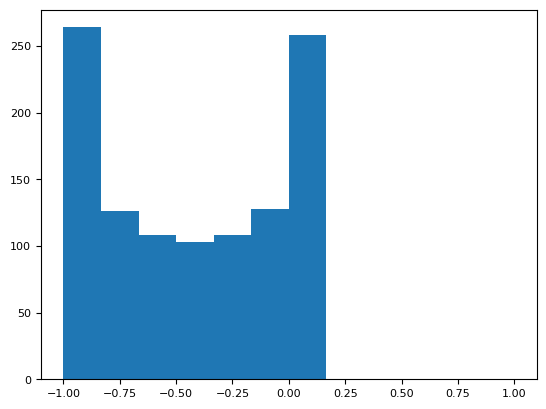

<Figure size 640x480 with 0 Axes>

In [8]:
# transform source position into local coordinates for each time step
local_coords = model.position.transform_to(frames)

# look at the minimum and maximum zenith angle (0 = above, 180 = below)
zen_angles = local_coords.zen.value

# zenith angle binning
cos_zen_bins = np.linspace(-1, 1, 13)
cos_zen_binc = 0.5 * (cos_zen_bins[:-1] + cos_zen_bins[1:])
zen_bins = np.arccos(cos_zen_bins) * 180 / np.pi
zen_binc = np.arccos(cos_zen_binc) * 180 / np.pi

# compute visibility time for each zenith angle bin
vis_hist = np.histogram(np.cos(zen_angles*np.pi/180), bins=cos_zen_bins)
vis_times = vis_hist[0] / vis_hist[0].sum() * u.yr
plt.stairs(vis_hist[0], vis_hist[1], fill=True)
plt.show()
if analysisconfig.get_value("write_KM3NeT_plots", "io"):
    plt.savefig(analysisconfig.get_file("km3net/plots/KM3NeT_visibility_"+source_name+".pdf"))

## Pseudo data sets

Reading the pseudo datasets, the content will be displaysed in the following notebook

In [9]:
ext = analysisconfig.get_value("km3net_pseudodata_extension", "io") # folder name extension when using different data sets
filepath = str(analysisconfig.get_file("km3net/pseudodata/KM3NeT_"+source_name+ext))

dspath = filepath + "/KM3NeT_"+source_name+ext+"_datasets.yaml"
modelpath = filepath + "/KM3NeT_"+source_name+ext+"_models.yaml"
bkgpath = filepath + "/npred_bkg_km3net"

datasets_km3net = Datasets.read(filedata=dspath, filemodel=modelpath)

print ("Read the following sets:", datasets_km3net.names, "from path", filepath)

npred_bkg_mu = []
npred_bkg_nu = []
datasets = []

n_datasets = len(datasets_km3net.names)

for i in range(n_datasets):
    datasets.append(datasets_km3net["nu"+str(i+1)])
    npred_bkg_mu.append(Map.read(bkgpath + "/"+source_name+"_npred_mu_0"+str(i+1)+".fits"))
    npred_bkg_nu.append(Map.read(bkgpath + "/"+source_name+"_npred_nu_0"+str(i+1)+".fits"))

Read the following sets: ['nu1', 'nu2', 'nu3', 'nu4', 'nu5', 'nu6', 'nu7'] from path /home/msmirnov/working_space/cta-and-km3net/data/km3net/pseudodata/KM3NeT_VelaX_10y


(<Figure size 640x480 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>,
 <matplotlib.colorbar.Colorbar at 0x7ff788255ac0>)

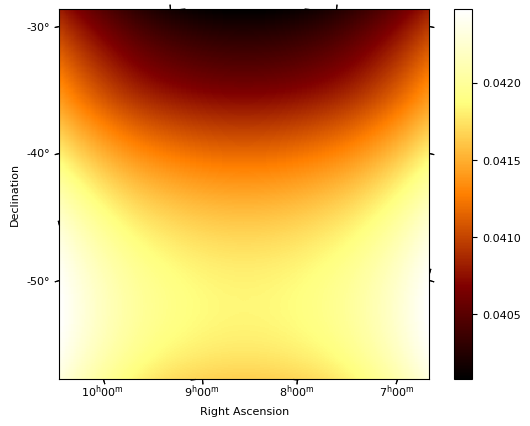

In [10]:
# Neutrino background, first zenith angle bin (upgoing)
npred_bkg_nu[0].sum_over_axes().plot(add_cbar=True)

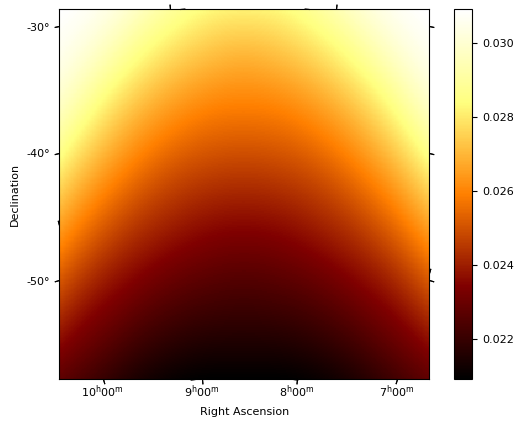

In [11]:
# Neutrino background, intermediate zenith angle bin
npred_bkg_nu[3].sum_over_axes().plot(add_cbar=True);

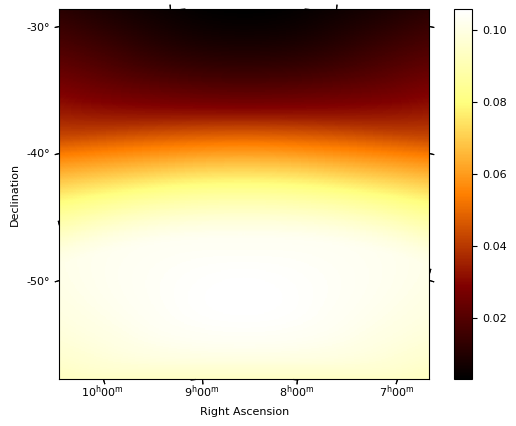

In [12]:
# Neutrino background, last zenith angle bin (horizon)
npred_bkg_nu[-1].sum_over_axes().plot(add_cbar=True);

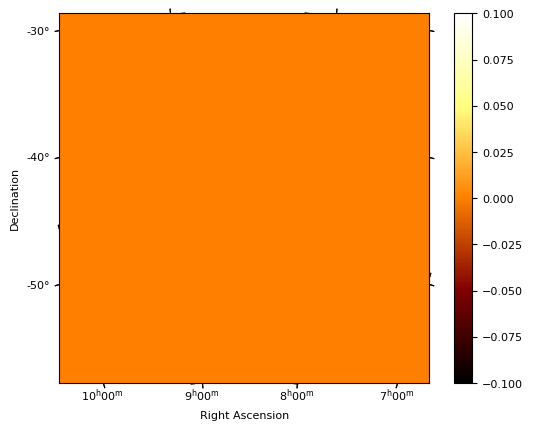

In [13]:
# Muon background, first zenith angle bin (upgoing)
npred_bkg_mu[0].sum_over_axes().plot(add_cbar=True);

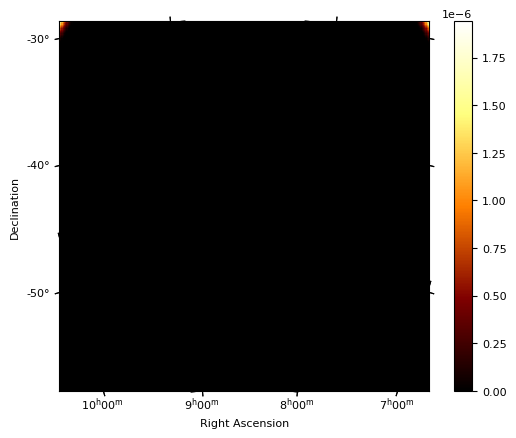

In [14]:
# Muon background, intermediate zenith angle bin
npred_bkg_mu[3].sum_over_axes().plot(add_cbar=True);

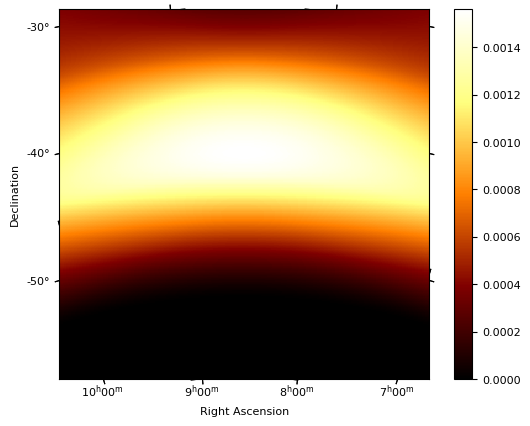

In [15]:
# Muon background, last zenith angle bin (horizon)
npred_bkg_mu[-1].sum_over_axes().plot(add_cbar=True);

## Plot example datasets

The parameters of the following plots are retrieved such that the same parameter names are used as in Creat_KM3NeT_datasets.

In [16]:
npred_bkg_sum = []
for i in range(n_datasets):
    bkg_sum = datasets[i].npred()
    bkg_mu = bkg_sum - npred_bkg_nu[i]
    npred_bkg_sum.append(bkg_sum)

More conventional approach to get flux model.

In [17]:
# read flux model
model_pars_PD = np.loadtxt(f'../data/models/modelfits/input_model_{model.fluxtype}_{source_name}.txt')

In [18]:
ECPL_PD = ExponentialCutoffPowerLaw(
    amplitude = model_pars_PD[0]/u.eV,
    e_0       = model_pars_PD[1]*u.TeV,
    alpha     = model_pars_PD[2],
    e_cutoff  = model_pars_PD[3]*u.TeV,
    beta      = model_pars_PD[4]
)
nu_ECPL_PD = PionDecayKelner06(ECPL_PD, particle_type='muon_neutrino', oscillation_factor=0.5)
spectral_model = NaimaSpectralModel(nu_ECPL_PD, distance=model.get_distance)

if source_name != 'HESSJ1908':
    spatial_model = DiskSpatialModel(
        lon_0 = model.position.ra,
        lat_0 = model.position.dec,
        r_0   = model.get_radius,
        frame = 'icrs'
    )
else:
    spatial_model = GaussianSpatialModel(
        lon_0 = model.position.ra,
        lat_0 = model.position.dec,
        r_0   = model.get_radius,
        frame = 'icrs'
    )
model_signal = SkyModel(
    spectral_model=spectral_model, 
    spatial_model=spatial_model, 
    name=source_name)

In [19]:
%%time
datasets[0].models.append(model_signal)

# this use get_fluxmodel, but it gives some difference
# it needs to be figured out
# datasets[0].models.append(model.get_fluxmodel)

npred_sum = []
npred_src = []
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    for i in range(n_datasets):
        bkg_src = datasets[i].npred()
        src = bkg_src - npred_bkg_sum[i]
        npred_sum.append(bkg_src)
        npred_src.append(src)

geom = npred_bkg_nu[0].geom

CPU times: user 9.46 s, sys: 537 ms, total: 10 s
Wall time: 10 s


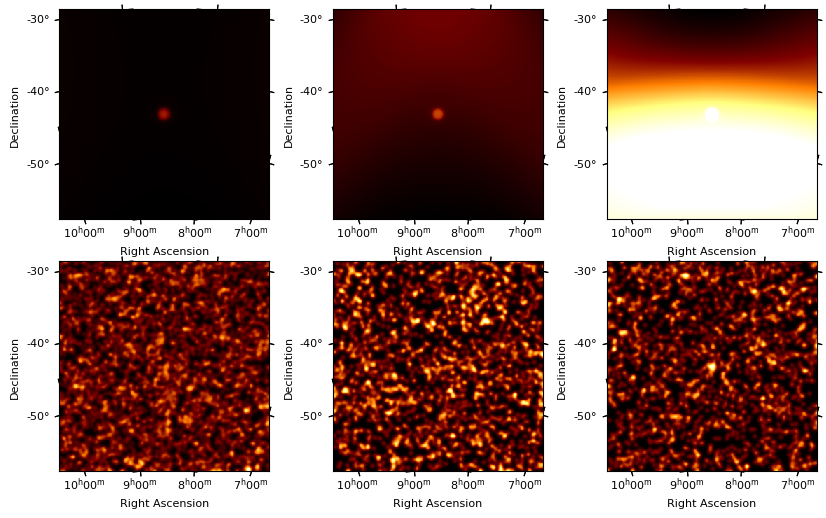

CPU times: user 3.35 s, sys: 484 ms, total: 3.83 s
Wall time: 2.92 s


In [20]:
%%time
fig, axes = plt.subplots(2, 3, figsize=(10, 6), subplot_kw=dict(projection=geom.to_image().wcs))

rs = np.random.RandomState(seed=314)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    for i in range(n_datasets):
        datasets[i].fake(rs)  

for i, ds_idx in enumerate([1, 4, -1]):
    npred_sum[ds_idx].sum_over_axes().plot(ax=axes[0][i], stretch='sqrt', norm=plt.Normalize(vmax=0.1))
    datasets[i].counts.smooth(0.25*u.deg).sum_over_axes().plot(ax=axes[1][i])

plt.show()

In [21]:
%%time
# Compute npred for source model
npred_bkg_nu_all = WcsNDMap(geom)
npred_bkg_mu_all = WcsNDMap(geom)
npred_src_all = WcsNDMap(geom)
npred_sum_all = WcsNDMap(geom)
counts_all = WcsNDMap(geom)

for i in range(n_datasets):
    counts_all += datasets[i].counts
    npred_src_all += npred_src[i]
    npred_sum_all += npred_sum[i]
    npred_bkg_nu_all += npred_bkg_nu[i]
    npred_bkg_mu_all += npred_bkg_mu[i]  

CPU times: user 87.7 ms, sys: 4.86 ms, total: 92.5 ms
Wall time: 92.1 ms


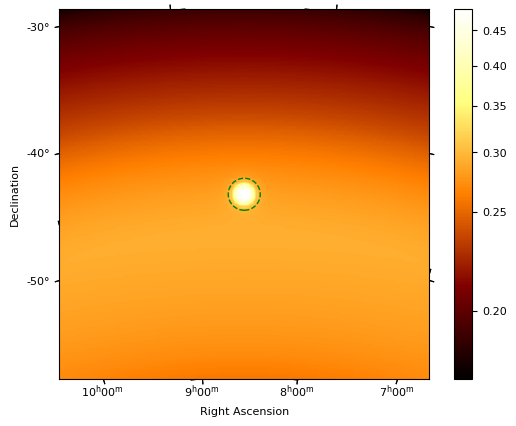

In [22]:
# Source region
src_region = CircleSkyRegion(model.position, model.get_radius + 0.5*u.deg)
src_reg_mask = geom.to_image().region_mask([src_region])

# Predicted counts, summed for all datasets
fig,ax,cbar = npred_sum_all.sum_over_axes().plot(add_cbar=True, stretch='sqrt')
src_reg_pix = src_region.to_pixel(ax.wcs)
src_reg_pix.plot(ax=ax, ls='--');

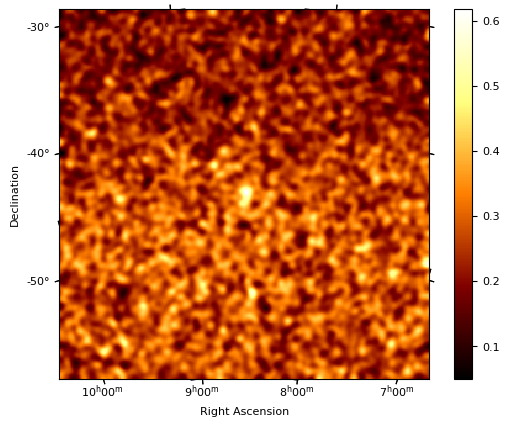

In [23]:
# Fake counts, summed for all datasets
counts_all.sum_over_axes().smooth(0.25*u.deg).plot(add_cbar=True);

## Count maps

Figure 9: Counts map of a pseudo KM3NeT data set based on the PD model for Vela X with 10 years of observation time. The counts are Poisson-randomised based on the model prediction for Vela X, summed over all energies and smoothed with a 0.25◦ Gaussian. The white dashed circle shows the source region for which the counts spec tra shown in Fig. 10 have been extracted (same region as in Fig. 7).

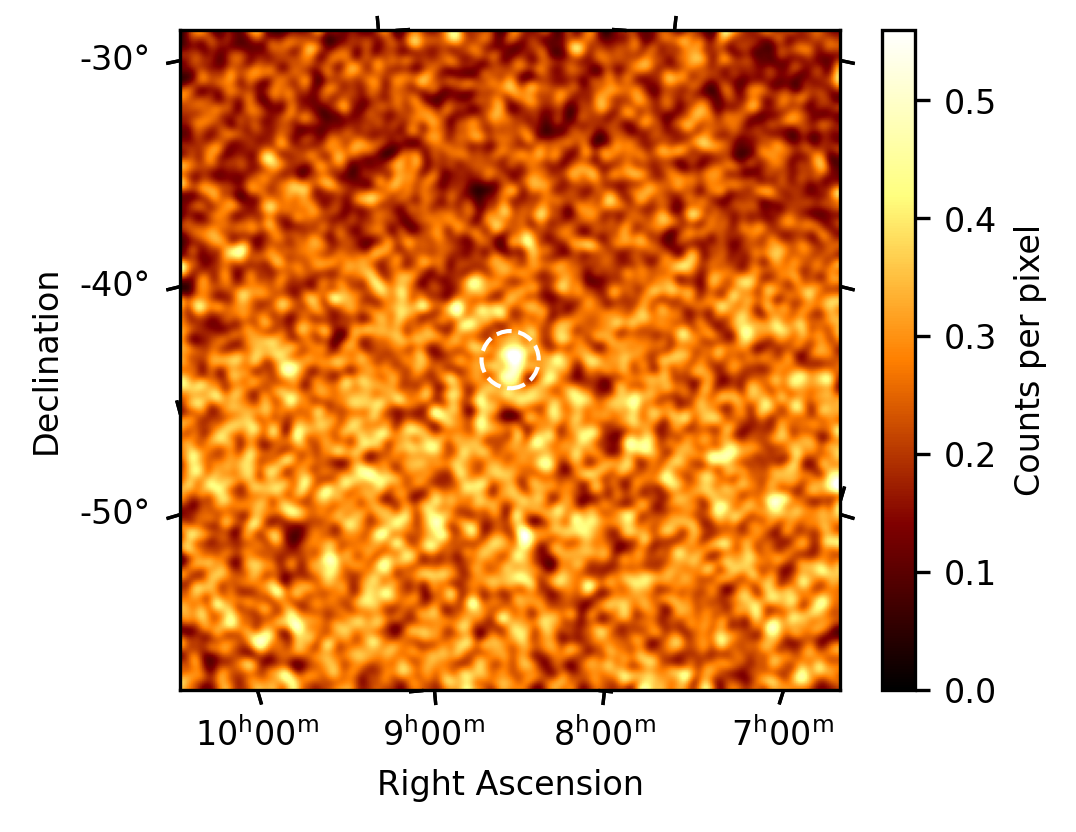

In [28]:
fig_width = 8.8 / 2.54
fig_height = 2.75
cmap = cm.afmhot

fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
fig, ax, cbar = counts_all.sum_over_axes().smooth(0.25 * u.deg).plot(add_cbar=True)

data = counts_all.sum_over_axes().smooth(0.25 * u.deg).data
im = ax.imshow(data, cmap=cmap, vmin=0.0, vmax=0.56)
src_reg_pix = src_region.to_pixel(ax.wcs)
src_reg_pix.plot(ax=ax, ec="w", ls="--")


norm = colors.Normalize(vmin=0.0, vmax=0.56)
cbar.update_normal(cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label("Counts per pixel")

plt.subplots_adjust(left=0.15, right=0.95, bottom=0.17, top=0.97)

if analysisconfig.get_value("write_KM3NeT_plots", "io"):
    for form in ['png', 'pdf']:
        fig.savefig(analysisconfig.get_file("km3net/plots/map_KM3NeT_counts_summed_PD_"+source_name+"."+form))

## Counts spectrum

Counts spectra for the Vela X KM3NeT PD data set, extracted for a region encompassing the source (cf. Fig. 9). The coloured lines denote the number of predicted counts within the source region for an observation time of 10 years. The black data points visualise one random Poisson realisation, drawn from the model predictions.

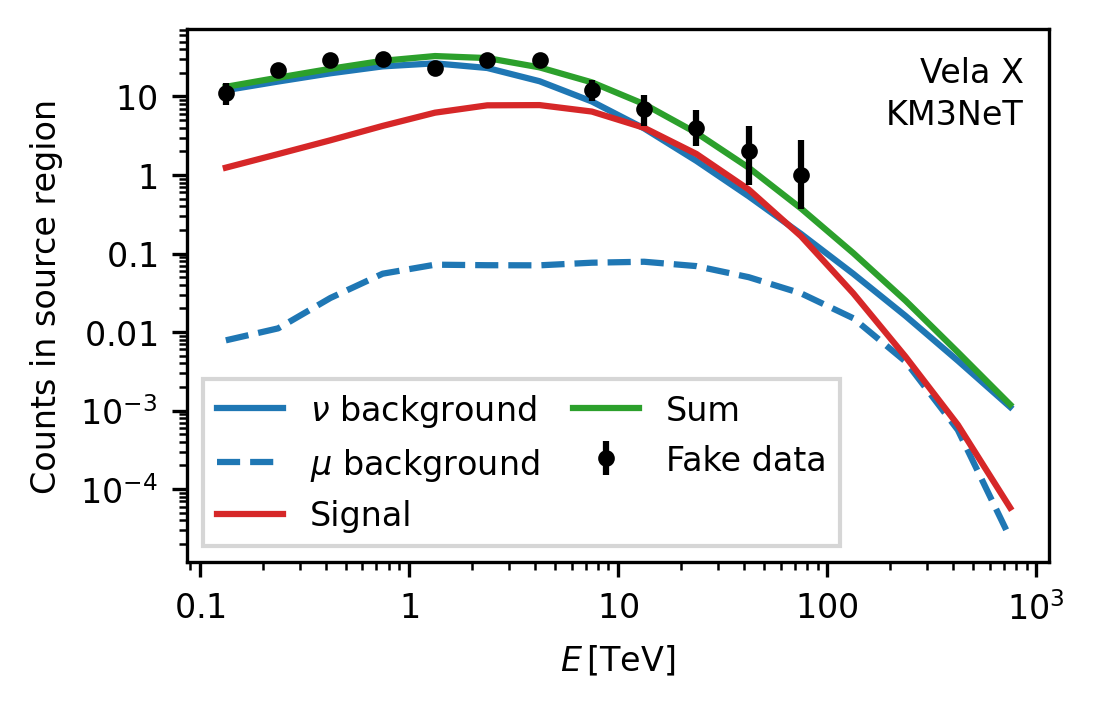

In [25]:
fig_width = 8.8 / 2.54
ax_width = 0.83
fig_height = 2.2
ax_height = fig_width * ax_width / 1.618 / fig_height # golden ratio

energy_axis = MapAxis.from_bounds(1e2, 1e6, nbin=16, unit='GeV', name='energy', interp='log')

fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
ax = fig.add_axes([0.16, 0.18, ax_width, ax_height])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E\,[\mathrm{TeV}]$')
ax.set_ylabel('Counts in source region')

e = energy_axis.center.value/1e3
ax.plot(e, npred_bkg_nu_all.data[:,src_reg_mask].sum(axis=1), color='tab:blue', label=r'$\nu$ background')
ax.plot(e, npred_bkg_mu_all.data[:,src_reg_mask].sum(axis=1), color='tab:blue', ls='--', label=r'$\mu$ background')
ax.plot(e, npred_src_all.data[:,src_reg_mask].sum(axis=1), color='tab:red', label='Signal')
ax.plot(e, npred_sum_all.data[:,src_reg_mask].sum(axis=1), color='tab:green', label='Sum')
cts = counts_all.data[:,src_reg_mask].sum(axis=1)
e = e[cts>0]
cts = cts[cts>0]
ax.errorbar(e, cts, xerr=None, yerr=plot_utils.feldman_cousins_errors(cts).T,
            linestyle='None', marker='o', markersize=3, color='k', label='Fake data', zorder=8)

ax.text(0.97, 0.95, plot_utils.source_name_labels[source_name], ha='right', va='top', transform=ax.transAxes)
ax.text(0.97, 0.87, 'KM3NeT', ha='right', va='top', transform=ax.transAxes)

plot_utils.format_log_axis(ax.xaxis)
plot_utils.format_log_axis(ax.yaxis)

ax.legend(loc='lower left', ncol=2, columnspacing=1)

if analysisconfig.get_value("write_KM3NeT_plots", "io"):
    for form in ['png', 'pdf']:
        fig.savefig(analysisconfig.get_file("km3net/plots/counts_reg_KM3NeT_counts_summed_PD_"+source_name+"."+form))